In [1]:
!python --version

Python 3.10.12


In [1]:
!pip install scanpy

Google Colab uses Python 3.10.2, while Helical requires Python 3.11 and above. I upgraded the Google Colab Python version to 3.11, but I've got several other issues. As a temporary solution I changed the Python version requirements on a forked version of the library. I looked trhough the dependencies and I haven't found a strict requirement for having Python 3.11. Though ideally the right solution would be to upgrade the Python version in Google Colab.

In [2]:
!pip install git+https://github.com/giogix2/helical.git@helical_python_3_10

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [86]:
import os
import requests
import scanpy as sc
from anndata import AnnData
import umap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import spatial

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import torch
from helical.models.scgpt.model import scGPT, scGPTConfig
from helical.models.geneformer.model import Geneformer, GeneformerConfig

I've taken the following snippet from [this notebook](https://github.com/helicalAI/helical/blob/release/examples/notebooks/Geneformer-vs-UCE.ipynb).
Note: initially I used the dataset from the notebook [Cell-Type-Annotation.ipynb](https://github.com/helicalAI/helical/blob/release/examples/notebooks/Cell-Type-Annotation.ipynb). However, the anndata dataset used in this notebook contains normalized gene expressions stored as floating values. This is incompatible with both the scGPT and GeneFormer model, because of a check in [here](https://github.com/helicalAI/helical/blob/release/helical/models/base_models.py#L84) which was recently introduced.

In [85]:
url = "https://helicalpackage.blob.core.windows.net/helicalpackage/data/10k_pbmcs_proc.h5ad"

# Extract the filename and download the file
filename = url.split("/")[-1]

# Check if the file already exists in the current directory
if os.path.exists(filename):
    print(f"Files already exist. Skipping downloads.")
else:
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {filename} successfully.")
    else:
        print(f"Failed to download {filename}.")

adata_original = sc.read_h5ad("10k_pbmcs_proc.h5ad")
adata = adata_original.copy()

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_config = GeneformerConfig(batch_size=16,device=device)
geneformer = Geneformer(configurer=model_config)
data = geneformer.process_data(adata, nproc=1, gene_names="gene_symbols")

In [7]:
def get_perturbed_embeddings(adata: AnnData, model: Geneformer, perturbed_genes: list[str] = []):
    """
    Perturb genes in an AnnData object and get the embeddings.
    The genes are knocked out by assigning their expression to zero.

    Args:
      adata: An AnnData object containing gene expression data.
      model: A Geneformer model object.
      perturbed_genes: List of the genes to be knocked out.

    Returns:
      Numpy array containing the embeddings from the Geneformer model.
    """

    adata_copy = adata.copy()

    genes_in_dataset = set(adata_copy.var['gene_symbols'].tolist())
    for gene in perturbed_genes:
        if gene not in genes_in_dataset:
            raise ValueError(f"Gene {gene} not found in the dataset.")

    if perturbed_genes:
        # Knockout a gene by setting its expression to 0.
        adata_copy[:, perturbed_genes] = 0

    data = model.process_data(adata_copy, nproc=1, gene_names="gene_symbols")
    embeddings = geneformer.get_embeddings(data)
    return embeddings

# Gene perturbation analysis

In this section we study the impact on the embeddings from a GeneFormer model when genes are perturbed sequentially.

In [9]:
def get_cosing_similarity(embedding_orig, embedding_perturb):
    list_genes_to_remove = []
    list_min_cosine_similarities = []

    res = []
    for i, embedding_orig in enumerate(embeddings_orig):
        embedding_perturb = embeddings_perturb[i]
        result = 1 - spatial.distance.cosine(embedding_orig, embedding_perturb)
        res.append(result)
    return res

We run a visual analysis on a subset of N observations from the PBMC dataset. We use the GeneFormer model to generate embeddings using the original data (non perturbed genes). At the same time we generate embeddings for the same sample while sequentially perturbing an increasing number of genes. This is done because it's difficult to select a gene which has a big impact on the embeddings when perturbed. Knowcking out more than one gene shows a bigger effect on the generatee embeddings, and which helps confirming whether the model is able to project the embeddings for perturbed and non-perturbed genes far apart.

At the same time, we measure the cosine similarity of pairs of embeddings from the same observation with and without perturbation. We plot the cosine similarity for each observation every time a new set of perturbed genes is selected, along side the respective UMAP projections.

From the visualizations it's possible to observe that when only one gene is knocked out, the impact on the embeddings is minimal, with the lowest cosine similarity close to 0.99. Also, the points in the UMAP are not clearly distinguishable. A clear separation between the embeddings is shown when more than 20 genes are perturbed, however, even when the number of knocked out genes is more than 80, some observations show high cosine similarities (above 0.97).

Considerations and possible improvements
* This is a simple visualization with a limited subset of observations. However, we should expect different levels of impact of perturbations on different cell types. Instead of visualizing all the cell types in a single plot, an analysis when grouping observations per cell type should be done (see next section).
* In this excercise, the genes to perturb have been chosen somwhat randomly. We sorted the genes by their exressions, from the maximum to the minimum with the assumption that genes with higher expression would determine a bigger impact on gene perturbations. However, this is not necessarely true. Instead, I tried to select genes by looking at the highly variable genes (HVGs) fields in the adata.uns dictionary structure. These genes have higher variability in expression across cell types, and might cause a bigger impact on embeddings when knocked out. However, in this dataset all the genes have hvg=True.
* Another possible way to select genes with high perturbation effects is too select genes that have higher cross-gene interactions in a Gene Regulatory Network. In fact, in reality when a gene is knocked out, it could affect the expression of other genes as well. So perturbing a gene by setting its expression to zero is only an approximation.

In [36]:
n_obs = 100
adata = adata_original[:n_obs]

# Generate the embeddings of N observations without perturbation
embeddings_orig = get_perturbed_embeddings(adata=adata, model=geneformer)

dict_cosine_similarities = {}
list_umas_dfs = []
for n_perturbed_genes in range(1, 100, 20):
    # Select genes which shown high expression level
    genes_sort_by_expression = adata.to_df().max().sort_values(ascending=False)
    list_genes_to_remove = genes_sort_by_expression[:n_perturbed_genes].index.tolist()

    # Generate the embeddings of N observations with perturbed genes
    embeddings_perturb = get_perturbed_embeddings(adata=adata,
                                              model=geneformer,
                                              perturbed_genes=list_genes_to_remove)

    # Run Umap on perturbed/non-perturbed embeddings
    embeddings = np.concatenate([embeddings_orig, embeddings_perturb])
    reducer = umap.UMAP(min_dist=0.2, n_components=2, n_epochs=None,n_neighbors=3)
    mapper = reducer.fit(embeddings)

    # Create dataframe with the Umap values to plot in the next cell
    df_plot = pd.DataFrame(mapper.embedding_, columns=['px','py'])
    df_plot.loc[:n_obs-1, ['perturbed']] = 0
    df_plot.loc[n_obs:, ['perturbed']] = 1
    list_umas_dfs.append(df_plot)

    # Mesure Cosine similarity between each pair of perturbed/non-perturbed embeddings
    list_similarities = get_cosing_similarity(embeddings_orig, embeddings_perturb)
    dict_cosine_similarities[n_perturbed_genes] = list_similarities

#### Plot similarities and Umap

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


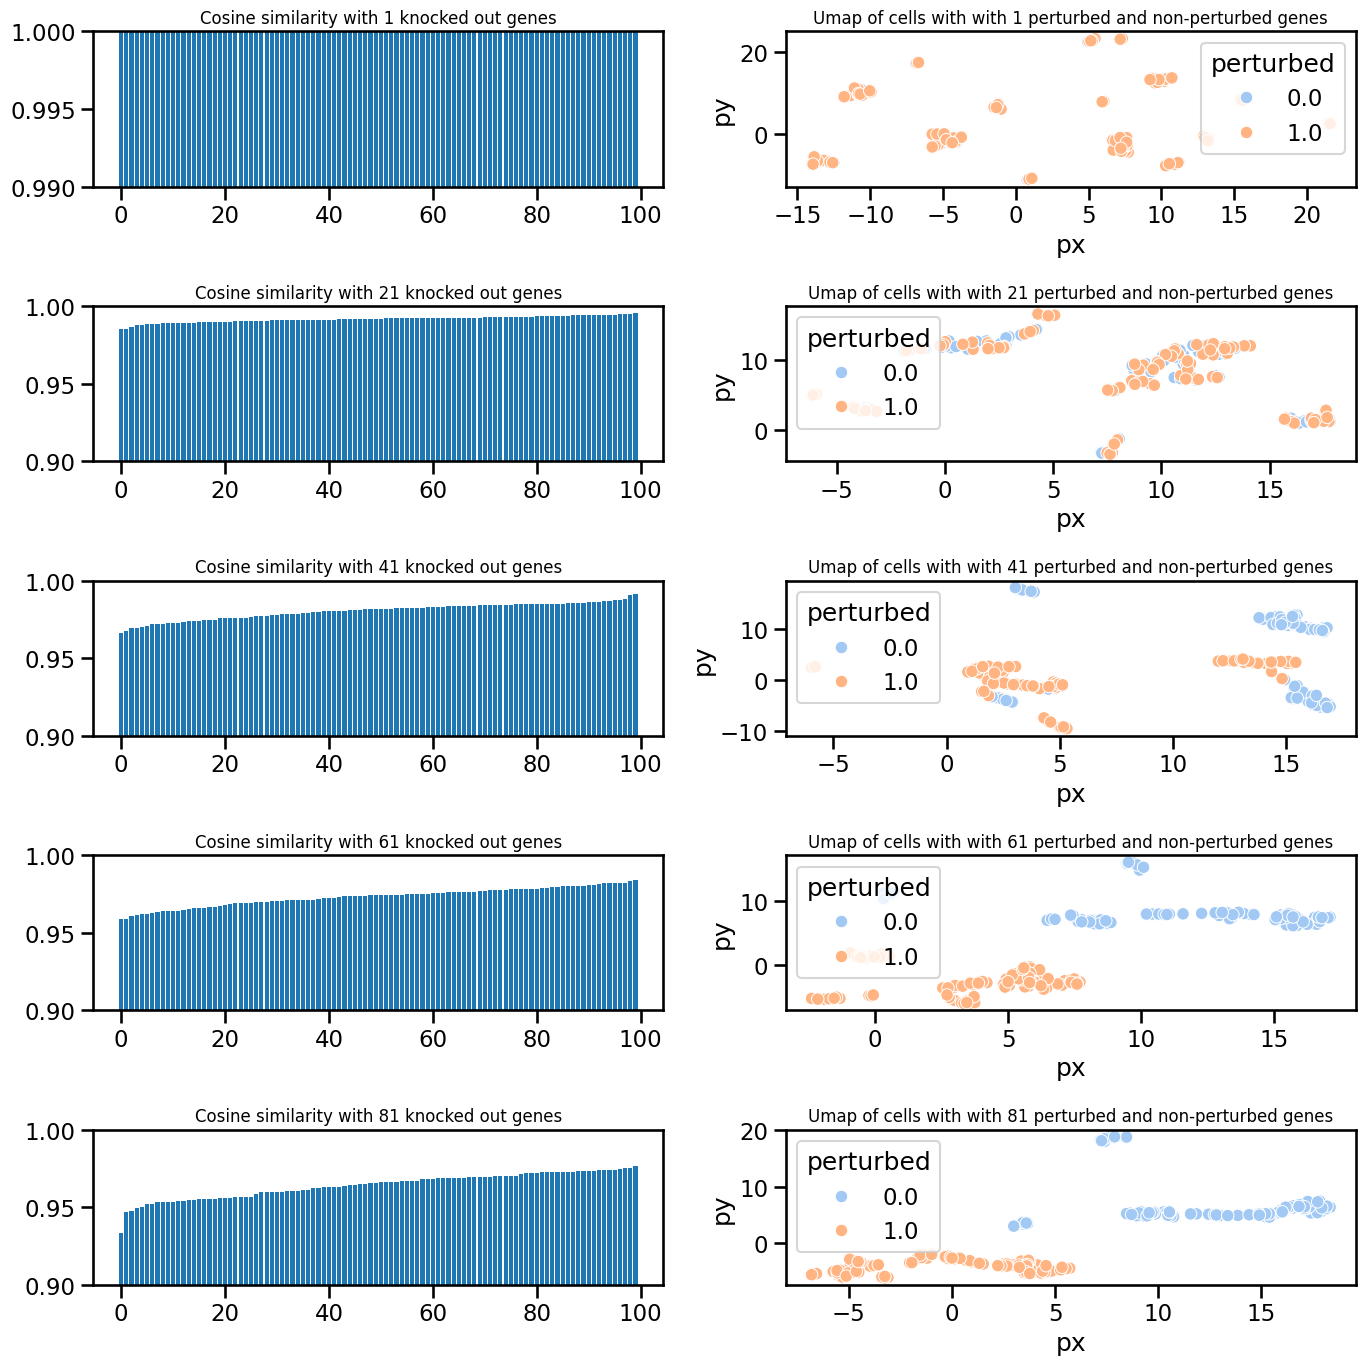

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [35]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(14, 14))

for i, n_perturbed_genes in enumerate(range(1, 100, 20)):
  list_cosines = sorted(dict_cosine_similarities[n_perturbed_genes])
  axs[i, 0].bar(range(len(list_cosines)), list_cosines)

  min_ylim = 0.99 if n_perturbed_genes < 20 else 0.9
  axs[i, 0].set_ylim(min_ylim, 1)
  axs[i, 0].set_title(f'Cosine similarity with {n_perturbed_genes} knocked out genes',
                      fontsize=12)

  df_plot = list_umas_dfs[i]

  sns.scatterplot(data=df_plot, x='px', y='py', hue='perturbed', sizes=(50,200),
                  ax=axs[i, 1], palette="pastel")
  axs[i, 1].set_title(f'Umap of cells with with {n_perturbed_genes} perturbed and non-perturbed genes',
                      fontsize=12)

  plt.tight_layout()

In [ ]:
print('Minimum/Mean/Maximum cosine similarity when N genes are perturbed')
for i, n_perturbed_genes in enumerate(range(1, 100, 20)):
  list_cosines = sorted(dict_cosine_similarities[n_perturbed_genes])
  print(f'{n_perturbed_genes} genes perturbed. Min: {min(list_cosines)}, Mean: {np.mean(list_cosines)}, Max: {max(list_cosines)}')

Minimum/Mean/Maximum cosine similarity when N genes are perturbed
1 genes perturbed. Min: 0.9999999721455649, Mean: 0.9999999936924542, Max: 1.0
21 genes perturbed. Min: 0.9849991449553467, Mean: 0.9915203390527872, Max: 0.9955561677540414
41 genes perturbed. Min: 0.9664891335353819, Mean: 0.9804232809433734, Max: 0.9914653220616437
61 genes perturbed. Min: 0.9588982968433801, Mean: 0.9731450186520257, Max: 0.9839480632380171
81 genes perturbed. Min: 0.933659807493409, Mean: 0.9641533977642706, Max: 0.9764530352133443


## Embedding similarity per cell type

I experimentally identified a potential gene (gene TMSB4X) that has a big impact on the embeddings when knocked out. This was found somewhat empirically from the analysis in the previous cell, and while training models in the next section.
In this section we analyse the impact of perturbation on the gene TMSB4X per cell type. This is because intuitively, not all the cells get affected equally when a knock out is done. To investigate what's the effect on each cell type when perturbing a certain gene, we show the average distance between perturbed and non-perturbed observation for each cell type.

In [74]:
list_genes_to_remove = ['TMSB4X']
adata = adata_original

# Generate the embeddings of N observations without perturbation
embeddings_orig = get_perturbed_embeddings(adata=adata, model=geneformer)

# Generate the embeddings of N observations with perturbed genes
embeddings_perturb = get_perturbed_embeddings(adata=adata,
                                          model=geneformer,
                                          perturbed_genes=list_genes_to_remove)

list_similarities = get_cosing_similarity(embeddings_orig, embeddings_perturb)

df = adata.to_df()
df['cell_type'] = adata.obs['cell_type']
df['similarities'] = list_similarities

The perturbation of the gene TMSB4X yields the biggest impact on the CD8T cells. However, the mean cosine similarity between cells is still within the same range (above 0.99). Further investigation is needed to determine what is the level of cosine similarity that determines a clear identification of cells with perturbed and non-perturbed genes.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-69-813fa0402527>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = df.groupby('cell_type').similarities.mean().sort_values(ascending=False).plot(kind='bar',


Text(0, 0.5, 'Average cosine similarity')

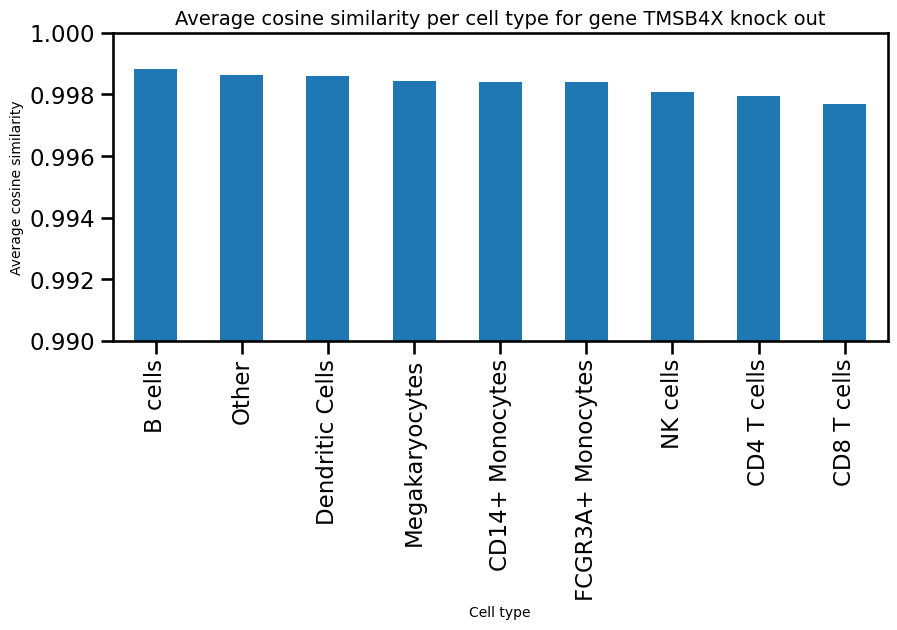

In [69]:
title = 'Average cosine similarity per cell type for gene TMSB4X knock out'
xlab = 'Cell type'
ylab = 'Average cosine similarity'
ax = df.groupby('cell_type').similarities.mean().sort_values(ascending=False).plot(kind='bar',
                                                                              ylim=(0.99, 1),
                                                                              figsize=(10, 4))
plt.title(f"Average cosine similarity per cell type for gene TMSB4X knock out",
          fontsize=14)
plt.xlabel(xlab, fontsize=10)
plt.ylabel(ylab, fontsize=10)

# Perturbation prediction model training

In this section we train two models which predicts whether embeddings from the GeneFormer has been perturbed or not. Unlike in the previous section, here we use the full dataset for the exercise.

In [11]:
adata = adata_original
n_obs = adata.shape[0]

embeddings_orig = get_perturbed_embeddings(adata=adata, model=geneformer)

In [84]:
# Knock out gene TMSB4X and get embeddings from GeneFormer
list_genes_to_remove = ['TMSB4X']

embeddings_perturb = get_perturbed_embeddings(adata=adata,
                                              model=geneformer,
                                              perturbed_genes=list_genes_to_remove)

## Prepare dataset

We keep 20% of the dataset just for testing, while the remaining part of the dataset is split in 70%/30% train and test set respectively.

In [70]:
# Add labes to the embeddings arrays (0: not-perturbed, 1: perturbed)
embeddings_orig = np.hstack((embeddings_orig, np.zeros((n_obs, 1))))
embeddings_perturb = np.hstack((embeddings_perturb, np.ones((n_obs, 1))))

X = np.concatenate([embeddings_orig, embeddings_perturb])

In [71]:
X_train, X_test = train_test_split(X,
                                   train_size=0.8,
                                   test_size=0.2,
                                   random_state=42,
                                   stratify=X[:,-1])

X_train, X_val = train_test_split(X_train,
                                  train_size=0.7,
                                  test_size=0.3,
                                  random_state=42,
                                  stratify=X_train[:,-1])

X_train, y_train = X_train[:,:-1], X_train[:,-1]
X_val, y_val = X_val[:,:-1], X_val[:,-1]
X_test, y_test = X_test[:,:-1], X_test[:,-1]

y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

# Training

We start by training a logistic regression to use as a basline. The results can be compared with the neural network trained in the following cells. For now we use accuracy as a metric, since the Train/Val/Test datasets are balanced with 50%/50% positive and negatives samples. While training the neural network we also show the F1 score in the train and validation sets.

In [73]:
# Initialize the logistic regression model
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train.ravel())  # Flatten y_train if it's a column vector

# Make predictions on the test set
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9887406171809842


In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras import metrics

input_shape = (512,)

# define the model
perturbation_model = Sequential()
perturbation_model.add(Dense(256, activation='relu', input_shape=(512,)))
perturbation_model.add(Dense(128, activation='relu'))
perturbation_model.add(Dense(64, activation='relu'))
perturbation_model.add(Dense(1, activation='sigmoid'))

# compile the model
optimizer = Adam(learning_rate=0.001)
perturbation_model.compile(loss='BinaryCrossentropy',
                          optimizer=optimizer,
                          metrics=[metrics.F1Score(average='macro', threshold=0.5)])

perturbation_model.summary()

history = perturbation_model.fit(X_train, y_train,
                                 epochs=10,
                                 batch_size=16,
                                 validation_data=(X_val, y_val))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 172,545 (674.00 KB)

 Trainable params: 172,545 (674.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - f1_score: 0.8682 - loss: 0.2880 - val_f1_score: 0.9873 - val_loss: 0.0310
Epoch 2/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - f1_score: 0.9850 - loss: 0.0413 - val_f1_score: 0.9948 - val_loss: 0.0176
Epoch 3/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - f1_score: 0.9925 - loss: 0.0202 - val_f1_score: 0.9934 - val_loss: 0.0196
Epoch 4/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - f1_score: 0.9931 - loss: 0.0205 - val_f1_score: 0.9960 - val_loss: 0.0135
Epoch 5/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - f1_score: 0.9903 - loss: 0.0302 - val_f1_score: 0.9934 - val_loss: 0.0175
Epoch 6/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - f1_score: 0.9953 - loss: 0.0123 - val_f1_score: 0.9945 - val_loss: 0.0167
Epoch 7/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - f1_score: 0.9959 - loss: 0.0121 - val_f1_score: 0.9969 - val_loss: 0.0103
Epoch 8/10
840/840 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - f1_score: 0.9956 - loss: 0.0122 - val_f1_score: 0.

In [83]:
from sklearn.metrics import accuracy_score

# perturbation_model.evaluate(X_test, y_test)
y_pred = perturbation_model(X_test)
y_pred = (y_pred > 0.5)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}%')

Accuracy: 0.9969%
